In [1]:
import os, random, time, pymysql
import xgboost
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.kernel_ridge import KernelRidge as KR
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, Lars, Lasso
from sklearn.ensemble import RandomForestRegressor as RF

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

import warnings

from bayes_opt import BayesianOptimization

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
def _call_db_info(db_name):
    return pymysql.connect(
        host = '10.94.77.9',
        port= 13306,
        user = 'dxbot1',
        password='ensol2020!',
        db = db_name,
        charset = 'utf8')

def h_opt(theta1, g_alpha, k_dot, w_noise, rbf_l, tmp_prev_inven_col, tmp_var_sale_col, tmp_var_product_col):
    prev_inven_col = round(tmp_prev_inven_col)
    var_sale_col, var_product_col = round(tmp_var_sale_col), round(tmp_var_product_col)     
    
    train_set = opt_set[:-4].reset_index(drop=True)
    valid_set = opt_set[-4:].reset_index(drop=True)
    prev_inven_name   = [s for s in train_set.columns.values if 'prev_inven_' in s]    
    var_sale_name     = [s for s in train_set.columns.values if 'sales_prev_' in s]
    var_product_name  = [s for s in train_set.columns.values if 'product_prev_' in s]    
    train_x_name = prev_inven_name[:prev_inven_col]+var_sale_name[:var_sale_col]+var_product_name[:var_product_col]
    kernel =  theta1 * RBF(rbf_l) + WhiteKernel(w_noise)  + DotProduct(k_dot) ## RBF(2) + WhiteKernel(1)  + 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=g_alpha, n_restarts_optimizer=3)
    gp.fit(train_set[train_x_name], train_set['inven'])
    
    train_pred, train_sigma = gp.predict(train_set[train_x_name], return_std=True)
    valid_pred, valid_sigma = gp.predict(valid_set[train_x_name], return_std=True)
    x_pred_ = np.concatenate((train_pred, valid_pred)) 
    y_ = np.concatenate((train_set['inven'], valid_set['inven'])) 

    real_ = np.mean(np.ones_like(train_set['inven']) - np.clip(np.abs(train_set['inven'] - train_pred) / train_set['inven'] , 0, 1)) * 100     
    fcst_ = np.mean(np.ones_like(valid_set['inven']) - np.clip(np.abs(valid_set['inven'] - valid_pred) / valid_set['inven'] , 0, 1)) * 100    
    return fcst_    

In [3]:
dt_sql        = "select * from dt_table"
inven_sql     = "select * from inven_rslt"
prod_plan_sql = "select * from prod_plan"
prod_rslt_sql = "select * from prod_rslt"
prod_prev_sql = "select * from prod_prev"

sale_plan_sql = "select * from sale_plan"
sale_rslt_sql = "select * from sale_rslt"
sale_prev_sql = "select * from sale_prev"

conn = _call_db_info('gscm_e61d')
curs = conn.cursor()
curs.execute(dt_sql) 
dt_table = pd.DataFrame(curs.fetchall())
dt_table.columns = ['ww']
curs.execute("select column_name from information_schema.columns where table_name='inven_rslt' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(inven_sql) 
y_inven = pd.DataFrame(curs.fetchall())
y_inven.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='prod_plan' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(prod_plan_sql)
prod_plan = pd.DataFrame(curs.fetchall())
prod_plan.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='prod_rslt' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(prod_rslt_sql)
prod_rslt = pd.DataFrame(curs.fetchall())
prod_rslt.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='prod_prev' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(prod_prev_sql)
prod_prev = pd.DataFrame(curs.fetchall())
prod_prev.columns = tmp_col[0].values.tolist()


curs.execute("select column_name from information_schema.columns where table_name='sale_plan' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(sale_plan_sql)
sale_plan = pd.DataFrame(curs.fetchall())
sale_plan.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='sale_rslt' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(sale_rslt_sql)
sale_rslt = pd.DataFrame(curs.fetchall())
sale_rslt.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='sale_prev' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(sale_prev_sql)
sale_prev = pd.DataFrame(curs.fetchall())
sale_prev.columns = tmp_col[0].values.tolist()


conn.commit()
conn.close()

In [4]:
product_prev = []
tmp_prod_prev_ = [x.split('/') for x in prod_prev['target_ww']]
for i in range(0, prod_prev.shape[0]):
    tmp_ww = prod_prev['ww'].loc[i]
    tmp_s =  dt_table.index[dt_table['ww']==tmp_ww].tolist()[0]#-12
    tmp_split = pd.DataFrame([x.split(':') for x in tmp_prod_prev_[i]])
    if tmp_split.shape[1] > 1:
        tmp_split.columns = ['ww','qty']

        tmp_prev_qty = []
        for k in range(1, 13):
            if any(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']):
                tmp_ind = [i for i, x in enumerate(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']) if x]    
                tmp_prev_qty.append(float(tmp_split['qty'].loc[tmp_ind].values[0]))
            else:
                tmp_prev_qty.append(0.0)
        tmp_product_prev = prod_prev[['ww','date']].loc[i].values.tolist() + tmp_prev_qty
        product_prev.append(tmp_product_prev)
product_prev = pd.DataFrame(product_prev)
product_prev.columns = ['ww', 'date'] + ['product_prev_'+ str(x) for x in range(1,13)]
product_prev = product_prev.drop(['date'], axis=1)

sales_prev = []
tmp_sale_prev_ = [x.split('/') for x in sale_prev['target_ww']]
for i in range(0, sale_prev.shape[0]):    
    tmp_ww = sale_prev['ww'].loc[i]    
    tmp_s =  dt_table.index[dt_table['ww']==tmp_ww].tolist()[0]#-12
    if len(tmp_sale_prev_[i][0])>0:
        tmp_split = pd.DataFrame([x.split(':') for x in tmp_sale_prev_[i]])    
        tmp_split.columns = ['ww','qty']
        tmp_prev_qty = []
        for k in range(1, 13):
            if any(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']):
                tmp_ind = [i for i, x in enumerate(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']) if x]    
                tmp_prev_qty.append(float(tmp_split['qty'].loc[tmp_ind].values[0]))
            else:
                tmp_prev_qty.append(0.0)
        tmp_sales_prev = sale_prev[['ww','date']].loc[i].values.tolist() + tmp_prev_qty
        sales_prev.append(tmp_sales_prev)
    else:
        tmp_sales_prev = sale_prev[['ww','date']].loc[i].values.tolist()
        sales_prev.append(tmp_sales_prev)        
sales_prev = pd.DataFrame(sales_prev)
sales_prev = sales_prev.fillna(0)
sales_prev.columns = ['ww', 'date'] + ['sales_prev_'+ str(x) for x in range(1,13)]
sales_prev = sales_prev.drop(['date'], axis=1)

sales_prev['ww_new'] = [dt_table['ww'].loc[dt_table.index[dt_table['ww']==sales_prev['ww'][x]].tolist()[0]+2] for x in range(0, sales_prev.shape[0])]
sales_prev = sales_prev.drop('ww', axis=1)
tmp_d_set = pd.merge(y_inven, product_prev, how='left', left_on='ww', right_on='ww')
d_set = pd.merge(tmp_d_set, sales_prev, how='inner', left_on='ww', right_on='ww_new')
d_set = d_set.drop('ww_new', axis=1)


In [6]:
for current in np.arange(202101, 202117):#np.max(y_inven['ww'].values)
    dt_current = (dt_table.index[dt_table['ww'] == current].tolist()[0])-1
    pred_ww = dt_table['ww'].loc[dt_current+1:].values.tolist()
    opt_set = d_set.iloc[:d_set.index[d_set['ww'] == dt_table.loc[dt_current].values.tolist()[0]][0]+1,:]

    warnings.filterwarnings(action='ignore', category=UserWarning)
    param_bound = {'theta1' : (0, 10), 'g_alpha' : (0.0,0.99) , 'k_dot' : (0, 100), 'w_noise' : (0.0, 100), 'rbf_l' : (0, 10), 
                   'tmp_prev_inven_col' : (1,8), 'tmp_var_sale_col' : (1, 12), 'tmp_var_product_col' : (1, 12)}

    product_optimizer = BayesianOptimization(f=h_opt, pbounds=param_bound, verbose=2, random_state=1)
    product_optimizer.maximize(init_points=10, n_iter=30)
    print(product_optimizer.max['target'])

    g_alpha = product_optimizer.max['params']['g_alpha']
    k_dot = product_optimizer.max['params']['k_dot']
    rbf_l = product_optimizer.max['params']['rbf_l']
    theta1 =product_optimizer.max['params']['theta1']
    prev_inven_col = round(product_optimizer.max['params']['tmp_prev_inven_col'])
    var_product_col = round(product_optimizer.max['params']['tmp_var_product_col'])
    var_sale_col = round(product_optimizer.max['params']['tmp_var_sale_col'])
    w_noise = product_optimizer.max['params']['w_noise']
    print("Prev Inven : %d, Var Sale : %d, Var Product : %d"%(prev_inven_col, var_sale_col, var_product_col))

    train_set = opt_set

    prev_inven_name   = [s for s in train_set.columns.values if 'prev_inven_' in s]    
    var_sale_name     = [s for s in train_set.columns.values if 'sales_prev_' in s]
    var_product_name  = [s for s in train_set.columns.values if 'product_prev_' in s]
    train_x_name = prev_inven_name[:prev_inven_col]+var_sale_name[:var_sale_col]+var_product_name[:var_product_col]
    kernel =  theta1 * RBF(rbf_l) + WhiteKernel(w_noise)  + DotProduct(k_dot) ## RBF(2) + WhiteKernel(1)  + 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=g_alpha, n_restarts_optimizer=3)
    gp.fit(train_set[train_x_name], train_set['inven'])

    train_pred, train_sigma = gp.predict(train_set[train_x_name], return_std=True)

    current_ind = prod_plan.index[prod_plan['ww'] == current].tolist()[0]
    for i in range(0,var_product_col):
        #print(prod_plan.loc[current_ind-i])
        tmp_split = [x.split(":") for x in prod_plan['target_ww'].loc[current_ind-i].split("/")]
        tmp_split_df = pd.DataFrame(tmp_split)
        tmp_split_df.columns = ['ww', 'product_prev'+str(i+1)]
        tmp_ww_ind = [tmp_split_df['ww'].values.tolist().index(str(x)) for i, x in enumerate(pred_ww) if str(x) in tmp_split_df['ww'].values]
        tmp_prod_plan_test = tmp_split_df.iloc[tmp_ww_ind,:].reset_index(drop=True)    
        if i == 0 :
            prod_plan_test = tmp_prod_plan_test
        else:
            prod_plan_test = pd.merge(prod_plan_test, tmp_prod_plan_test, how='inner', on='ww')

    current_ind = sale_plan.index[sale_plan['ww'] == dt_table['ww'].loc[dt_current-2]].tolist()[0]
    #current_ind = sale_plan.index[sale_plan['ww'] == current].tolist()[0]
    for i in range(0,var_sale_col):
        #print(prod_plan.loc[current_ind-i])
        tmp_split = [x.split(":") for x in sale_plan['target_ww'].loc[current_ind-i].split("/")]
        tmp_split_df = pd.DataFrame(tmp_split)
        tmp_split_df.columns = ['ww', 'sales_prev'+str(i+1)]    
        tmp_split_df['ww'] = [str(dt_table['ww'].loc[dt_table.index[dt_table['ww']==int(tmp_split_df['ww'][x])].tolist()[0]+2]) for x in range(0, tmp_split_df.shape[0])]    
        tmp_ww_ind = [tmp_split_df['ww'].values.tolist().index(str(x)) for i, x in enumerate(pred_ww) if str(x) in tmp_split_df['ww'].values]    
        tmp_sale_plan_test = tmp_split_df.iloc[tmp_ww_ind,:].reset_index(drop=True)      
        if i == 0 :
            sale_plan_test = tmp_sale_plan_test
        else:
            sale_plan_test = pd.merge(sale_plan_test, tmp_sale_plan_test, how='left', on='ww')
    test_x = pd.merge(sale_plan_test, prod_plan_test, how='inner', on='ww')
    test_x = test_x.astype('float')
    test_x = test_x.astype({'ww': 'int'})       

    test_inven_init = np.array(train_set[['inven']+['prev_inven_'+str(x) for x in range(1,prev_inven_col)]][train_set['ww']==dt_table['ww'].loc[dt_current]]).reshape(-1)
    rslt_set, test_pred, test_sigma = [], [], []
    for i in range(0, test_x.shape[0]):    
        tmp_pred_inven_mean, tmp_pred_inven_std = gp.predict(np.concatenate([test_inven_init, test_x.iloc[i,1:]]).reshape(1,-1), return_std=True)
        test_pred.append(tmp_pred_inven_mean[0])
        test_sigma.append(tmp_pred_inven_std[0])
        tmp_rslt = np.concatenate([tmp_pred_inven_mean, test_inven_init, test_x.iloc[i,1:]])
        test_inven_init = np.insert(test_inven_init, 0, tmp_pred_inven_mean)[:prev_inven_col]
        rslt_set.append(tmp_rslt)
    rslt_set = pd.DataFrame(rslt_set)
    rslt_set['ww'] = test_x['ww']
    ww_col = rslt_set.columns[-1:].to_list()
    x_col = rslt_set.columns[:-1].to_list()
    set_col = ww_col + x_col
    rslt_set = rslt_set[set_col]
    rslt_set.columns = list(['ww','pred_inven'])+train_x_name #total_set.columns

    tmp_train_set = train_set[['ww','inven']].copy()
    tmp_train_set['inven_pred'] = train_pred
    tmp_train_set.head()
    tmp_test_set = pd.DataFrame({'ww' :  pred_ww[:len(test_pred)], 
                                 'inven' : np.repeat(-999, len(test_pred)),
                                 'inven_pred' : test_pred})
    tmp_day_set = pd.concat([tmp_train_set, tmp_test_set])
    tmp_day_set = tmp_day_set.reset_index(drop=True)

    tmp_train_sale = pd.merge(train_set['ww'], sale_rslt[['ww','sale']], how='inner', on='ww')
    tmp_test_sale = pd.DataFrame([x.split(':') for x in sale_plan['target_ww'][sale_plan['ww']==current].values.tolist()[0].split('/')])
    tmp_test_sale.columns = ['ww', 'sale']
    tmp_sale = pd.concat([tmp_train_sale, tmp_test_sale])
    tmp_sale = tmp_sale.astype({'ww': 'int'})  
    day_set = pd.merge(tmp_day_set, tmp_sale, how='inner', on='ww')
    day_set = day_set.astype({'sale' : 'float'})
    day_set_nonzero = day_set.copy()
    sale_col = np.where(day_set_nonzero.columns.values =='sale')[0][0]
    for i in range(0, day_set_nonzero.shape[0]):
        tmp_ids = i-1 if i-1 > 0 else 0    
        if day_set_nonzero['sale'].loc[i] == 0:        
            day_set_nonzero.iloc[i, sale_col] = day_set_nonzero.iloc[tmp_ids, sale_col]
            
    inven_d = []
    for i in range(0, day_set_nonzero.shape[0]):
        if i > 0 and i < day_set_nonzero.shape[0]-3:
            tmp_sale_avg = np.mean(day_set_nonzero['sale'][i:(i+4)].values)
            if i < day_set_nonzero[day_set_nonzero['ww'] == current].index[0] :
                tmp_inven = day_set_nonzero['inven'][i-1]    
            else:
                tmp_inven = day_set_nonzero['inven_pred'][i-1]    
            inven_d.append(round(tmp_inven / tmp_sale_avg * 6.76,1))
        else:
            inven_d.append(0)
    day_set_nonzero['inven_d'] = inven_d  

    insert_day_sql = "insert into inven_day values (%s, %s)"
    conn = _call_db_info('gscm_e61d')
    curs = conn.cursor()
    inven_day_rslt = [current, str('/'.join(list(map(lambda x : ':'.join([str(x) for x in day_set_nonzero.loc[x]]), range(0, day_set_nonzero.shape[0])))))]
    curs.execute(insert_day_sql, inven_day_rslt) 
    conn.commit()
    conn.close()

|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  83.09    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  80.38    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  76.5     |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  77.5     |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  74.83    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806    |  10.18    |  1.201    |  75.01    |
|  6        |  79.74    |  0.979    |  74.82    |  2.804    |  7.893    |  1.723    |  5.927    |  10.99    |  29.36    |
|  7        |  85.55    

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  15       |  84.77    |  0.4293   |  12.05    |  0.0      |  8.1      |  2.745    |  1.0      |  10.13    |  7.273    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  16       |  82.86    |  0.2697   |  14.23    |  0.0      |  9.677    |  5.843    |  1.0      |  4.718    |  8.436    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  17       |  80.56    |  0.4601   |  14.64    |  0.0      |  2.283    |  1.0      |  1.08     |  8.087    |  8.39     |
|  18       |  84.53    |  0.4049   |  10.53    |  2.602    |  9.961    |  2.047    |  3.184    |  9.47     |  10.35    |
|  19       |  79.16    |  0.9661   |  12.14    |  1.309    |  6.958    |  7.018    |  5.049    |  11.01    |  8.231    |
|  20       |  83.49    |  0.5683   |  11.69    |  2.224    |  9.387    |  1.348    |  4.254    |  10.82    |  3.23     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  21       |  80.0     |  0.0      |  11.35    |  0.0      |  10.0     |  1.0      |  2.807    |  5.885    |  7.09     |
|  22       |  83.56    |  0.5746   |  14.2     |  1.26     |  7.827    |  4.548    |  3.4      |  8.646    |  4.909    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  23       |  84.53    |  0.0      |  11.46    |  0.0      |  5.175    |  1.899    |  2.797    |  8.69     |  3.05     |
|  24       |  80.29    |  0.8162   |  12.2     |  3.619    |  7.247    |  1.281    |  5.034    |  9.685    |  6.933    |
|  25       |  84.83    |  0.221    |  13.78    |  0.4679   |  10.0     |  2.274    |  1.12     |  10.39    |  11.86    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  26       |  85.71    |  0.8598   |  12.06    |  0.0      |  9.001    |  1.584    |  4.233    |  8.813    |  14.52    |
|  27       |  83.97    |  0.0      |  14.1     |  3.469    |  10.0     |  2.506    |  3.218    |  7.388    |  15.01    |
|  28       |  79.61    |  0.6491   |  10.31    |  1.122    |  9.929    |  5.173    |  1.605    |  9.774    |  17.38    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  29       |  78.72    |  0.0      |  14.74    |  0.0      |  10.0     |  1.0      |  5.944    |  11.23    |  13.7     |
|  30       |  82.34    |  0.99     |  12.47    |  0.5703   |  7.718    |  2.154    |  2.138    |  7.309    |  12.46    |
|  31       |  84.49    |  0.7742   |  11.81    |  2.702    |  8.727    |  3.279    |  3.629    |  8.553    |  0.696    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  32       |  83.21    |  0.99     |  12.23    |  0.0      |  6.798    |  3.882    |  2.756    |  5.88     |  2.45     |
|  33       |  83.23    |  0.3734   |  8.575    |  0.6109   |  9.752    |  1.034    |  4.102    |  8.759    |  12.11    |
|  34       |  80.06    |  0.4149   |  10.01    |  1.078    |  6.389    |  2.457    |  6.23     |  5.522    |  14.85    |
|  35       |  83.57    |  0.6611   |  9.943    |  0.6121   |  5.237    |  4.046    |  3.761    |  9.554    |  0.4978   |
|  36       |  79.58    |  0.4853   |  16.07    |  2.889    |  8.815    |  3.181    |  5.544    |  5.427    |  11.12    |
|  37       |  84.42    |  0.3046   |  12.56    |  3.343    |  3.994    |  1.635    |  2.815    |  7.343    |  2.587    |
|  38       |  80.21    |  0.05367  |  11.27    |  0.4909   |  8.468    |  2.071    |  7.418    |  7.353    |  0.4322   |
|  39       |  81.01    |  0.8861   |  14.91    |  0.7461   |  6.93     |  2.841    |  1.826    |  5.882    |  6.577    |
|  40       |  81.01    

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  81.6     |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  77.72    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  78.84    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  74.71    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  74.6     |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806    |  10.18    |  1.201    |  75.01    |
|  6        |  73.39    |  0.979    |  74.82    |  2.804    |  7.893    |  1.723    |  5.927    |  10.99    |  29.36    |
|  7        |  82.93    

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  17       |  93.66    |  0.99     |  96.47    |  1.666    |  0.0      |  1.0      |  12.0     |  1.0      |  43.27    |
|  18       |  93.68    |  0.99     |  47.4     |  0.4655   |  10.0     |  1.0      |  12.0     |  1.0      |  64.95    |
|  19       |  92.87    |  0.0      |  54.98    |  2.197    |  10.0     |  1.0      |  3.555    |  1.0      |  62.67    |
|  20       |  93.66    |  0.99     |  51.66    |  8.123    |  4.171    |  1.0      |  12.0     |  1.0      |  59.55    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  21       |  93.66    |  0.99     |  89.14    |  9.233    |  0.0      |  1.0      |  12.0     |  1.0      |  39.59    |
|  22       |  93.68    |  0.0      |  60.59    |  9.886    |  10.0     |  1.0      |  12.0     |  1.0      |  64.9     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  23       |  93.91    |  0.99     |  92.17    |  0.0      |  0.0      |  7.216    |  12.0     |  1.0      |  34.56    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  24       |  93.66    |  0.99     |  91.28    |  0.0      |  9.736    |  1.0      |  12.0     |  1.0      |  39.43    |
|  25       |  83.21    |  0.0      |  50.68    |  10.0     |  10.0     |  1.0      |  12.0     |  11.75    |  66.44    |
|  26       |  93.15    |  0.99     |  90.96    |  4.53     |  4.619    |  8.0      |  12.0     |  1.0      |  45.62    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  27       |  93.66    |  0.99     |  83.6     |  0.0      |  0.0      |  1.0      |  12.0     |  1.0      |  33.29    |
|  28       |  93.66    |  0.0      |  96.28    |  6.208    |  5.221    |  1.0      |  12.0     |  1.0      |  28.27    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  29       |  93.66    |  0.99     |  90.6     |  0.0      |  0.0      |  1.0      |  12.0     |  1.0      |  19.49    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  30       |  84.38    |  0.99     |  95.95    |  0.0      |  0.0      |  1.0      |  12.0     |  10.38    |  32.36    |
|  31       |  93.91    |  0.0      |  87.33    |  6.695    |  6.79     |  7.392    |  12.0     |  1.0      |  30.93    |
|  32       |  94.18    |  0.0      |  88.96    |  10.0     |  6.657    |  2.146    |  12.0     |  1.0      |  19.93    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  33       |  93.15    |  0.99     |  82.56    |  6.078    |  0.0      |  8.0      |  12.0     |  1.0      |  21.34    |
|  34       |  93.15    |  0.0      |  93.09    |  2.084    |  10.0     |  8.0      |  12.0     |  1.0      |  19.85    |
|  35       |  92.92    |  0.0      |  93.84    |  10.0     |  1.89     |  7.021    |  4.158    |  1.0      |  21.29    |
|  36       |  93.66    |  0.0      |  91.86    |  7.295    |  2.33     |  1.0      |  12.0     |  1.0      |  8.777    |
|  37       |  93.52    |  0.99     |  84.66    |  2.574    |  7.64     |  1.0      |  4.816    |  1.0      |  13.37    |
|  38       |  93.66    |  0.99     |  100.0    |  10.0     |  10.0     |  1.0      |  12.0     |  1.0      |  15.76    |
|  39       |  84.06    |  0.7788   |  89.98    |  9.886    |  7.209    |  5.89     |  10.95    |  11.46    |  10.31    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  40       |  93.52    |  0.0      |  100.0    |  0.0      |  1.88     |  1.0      |  5.453    |  1.0      |  11.09    |
94.88331112726279
Prev Inven : 2, Var Sale : 2, Var Product : 11
|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  93.83    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  95.1     |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  92.05    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  95.81    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  95.64    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806 

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  25       |  95.88    |  0.99     |  47.76    |  5.105    |  0.0      |  5.771    |  9.365    |  1.0      |  80.33    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  26       |  93.55    |  0.99     |  97.69    |  1.045    |  0.0      |  1.0      |  12.0     |  1.0      |  41.73    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  27       |  93.55    |  0.99     |  87.06    |  7.497    |  0.0      |  1.0      |  12.0     |  1.0      |  45.42    |
|  28       |  95.19    |  0.99     |  47.09    |  2.726    |  5.83     |  8.0      |  3.922    |  1.0      |  81.87    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  29       |  95.18    |  0.99     |  54.78    |  6.342    |  0.0      |  7.908    |  5.062    |  1.0      |  81.87    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  30       |  94.63    |  0.99     |  89.1     |  0.0      |  0.0      |  8.0      |  12.0     |  1.0      |  36.49    |
|  31       |  95.0     |  0.99     |  48.63    |  8.482    |  10.0     |  1.0      |  7.724    |  1.0      |  61.37    |
|  32       |  93.32    |  0.99     |  58.54    |  10.0     |  10.0     |  1.0      |  12.0     |  1.0      |  60.17    |
|  33       |  94.12    |  0.99     |  45.3     |  0.6648   |  10.0     |  1.0      |  11.17    |  1.0      |  66.1     |
|  34       |  93.53    |  0.99     |  51.62    |  4.81     |  10.0     |  6.195    |  1.494    |  1.0      |  65.96    |
|  35       |  94.11    |  0.99     |  45.76    |  10.0     |  1.171    |  1.0      |  10.03    |  1.0      |  66.58    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  36       |  93.55    |  0.99     |  89.13    |  0.0      |  7.898    |  1.0      |  12.0     |  1.0      |  40.3     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  37       |  96.84    |  0.99     |  46.68    |  3.328    |  0.0      |  8.0      |  6.748    |  1.0      |  74.33    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  38       |  95.18    |  0.99     |  39.73    |  2.533    |  0.0      |  8.0      |  4.521    |  1.0      |  74.25    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  39       |  95.18    |  0.99     |  44.93    |  0.0      |  0.0      |  8.0      |  4.969    |  1.0      |  67.52    |
|  40       |  94.93    |  0.0      |  43.34    |  5.438    |  6.276    |  1.0      |  6.685    |  1.0      |  51.27    |
96.8352198782139
Prev Inven : 8, Var Sale : 1, Var Product : 7


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  95.78    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  95.9     |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  92.25    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  96.13    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  96.44    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806    |  10.18    |  1.201    |  75.01    |
|  6        |  95.16    |  0.979    |  74.82    |  2.804    |  7.893    |  1.723    |  5.927    |  10.99    |  29.36    |
|  7        |  96.87    

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  39       |  96.35    |  0.99     |  41.83    |  0.0      |  6.078    |  6.705    |  3.577    |  4.907    |  75.5     |
|  40       |  96.36    |  0.3577   |  11.25    |  0.5567   |  5.406    |  2.836    |  6.523    |  3.88     |  10.36    |
97.56744445433533
Prev Inven : 6, Var Sale : 1, Var Product : 6
|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  93.49    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  93.74    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  90.62    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  93.9     |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189  

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  31       |  91.53    |  0.99     |  15.19    |  4.924    |  8.554    |  5.134    |  6.759    |  4.481    |  0.0      |
|  32       |  92.56    |  0.0      |  13.85    |  3.531    |  8.608    |  1.0      |  5.873    |  2.789    |  7.483    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  33       |  90.52    |  0.0      |  53.44    |  0.0      |  10.0     |  8.0      |  1.0      |  1.0      |  73.73    |
|  34       |  92.32    |  0.561    |  48.63    |  0.482    |  6.409    |  4.982    |  6.103    |  1.0      |  77.35    |
|  35       |  92.82    |  0.3126   |  48.79    |  0.9457   |  10.0     |  3.7      |  2.987    |  3.098    |  77.14    |
|  36       |  93.36    |  0.03848  |  16.61    |  5.467    |  6.161    |  1.057    |  5.587    |  8.71     |  1.971    |
|  37       |  91.82    |  0.2223   |  15.68    |  4.63     |  8.282    |  2.535    |  2.187    |  7.957    |  4.738    |
|  38       |  91.84    |  0.1953   |  15.15    |  2.408    |  3.931    |  1.807    |  8.036    |  6.966    |  6.779    |
|  39       |  92.49    |  0.0      |  17.72    |  6.3      |  6.751    |  1.0      |  6.467    |  4.697    |  2.982    |
|  40       |  93.34    |  0.8571   |  52.73    |  7.944    |  5.971    |  2.88     |  10.39    |  1.0      |  72.3     |
93.3564922278467
Prev In

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  13       |  93.78    |  0.99     |  0.0      |  10.0     |  0.0      |  1.0      |  12.0     |  1.0      |  15.37    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  14       |  91.82    |  0.0      |  0.0      |  0.0      |  10.0     |  8.0      |  1.0      |  1.0      |  23.96    |
|  15       |  95.03    |  0.8381   |  6.384    |  1.537    |  5.021    |  1.0      |  5.652    |  10.1     |  13.48    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  16       |  94.14    |  0.1995   |  2.787    |  0.0      |  8.286    |  1.0      |  2.056    |  4.151    |  10.08    |
|  17       |  94.77    |  0.3386   |  11.18    |  1.036    |  6.858    |  1.0      |  4.561    |  5.191    |  18.1     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  18       |  92.63    |  0.0      |  4.214    |  0.0      |  1.576    |  1.0      |  1.0      |  10.13    |  19.73    |
|  19       |  94.67    |  0.99     |  5.25     |  2.33     |  9.796    |  1.0      |  7.804    |  6.28     |  15.91    |
|  20       |  94.58    |  0.7094   |  8.163    |  3.389    |  6.551    |  5.473    |  3.712    |  5.799    |  12.1     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  21       |  93.67    |  0.99     |  7.0      |  0.0      |  10.0     |  1.0      |  1.726    |  8.597    |  15.52    |
|  22       |  94.43    |  0.2721   |  5.125    |  0.92     |  4.254    |  1.0      |  6.224    |  3.701    |  15.56    |
|  23       |  95.79    |  0.0      |  2.898    |  5.199    |  6.885    |  1.0      |  3.952    |  6.811    |  16.18    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  24       |  95.23    |  0.0      |  0.0      |  2.433    |  7.201    |  1.0      |  5.919    |  8.703    |  15.89    |
|  25       |  95.03    |  0.0      |  4.078    |  8.776    |  5.751    |  1.0      |  6.06     |  10.15    |  12.09    |
|  26       |  95.33    |  0.0      |  5.504    |  7.849    |  6.966    |  1.0      |  6.534    |  8.415    |  20.35    |
|  27       |  94.41    |  0.0      |  7.929    |  10.0     |  7.254    |  1.0      |  2.269    |  3.698    |  17.46    |
|  28       |  93.79    |  0.0      |  12.37    |  7.263    |  4.488    |  1.017    |  9.393    |  10.93    |  15.13    |
|  29       |  89.98    |  0.7013   |  1.573    |  8.188    |  5.926    |  7.632    |  10.85    |  10.45    |  15.24    |
|  30       |  95.79    |  0.0      |  1.853    |  5.243    |  10.0     |  1.0      |  3.652    |  7.075    |  20.81    |
|  31       |  93.54    |  0.0      |  7.055    |  7.035    |  3.502    |  1.0      |  1.531    |  9.75     |  6.708    |
|  32       |  95.02    

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  33       |  92.59    |  0.99     |  17.29    |  0.0      |  10.0     |  1.0      |  10.14    |  1.022    |  7.805    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  34       |  92.73    |  0.0      |  16.79    |  0.0      |  2.007    |  6.363    |  1.0      |  5.121    |  11.2     |
|  35       |  95.0     |  0.99     |  3.773    |  4.682    |  7.138    |  1.0      |  5.22     |  4.143    |  21.07    |
|  36       |  93.48    |  0.0      |  2.865    |  8.486    |  9.821    |  1.0      |  2.05     |  10.54    |  17.64    |
|  37       |  92.86    |  0.6397   |  4.478    |  2.947    |  8.879    |  1.563    |  6.776    |  10.1     |  19.65    |
|  38       |  94.59    |  0.1262   |  1.385    |  9.29     |  7.158    |  1.648    |  4.375    |  5.583    |  21.18    |
|  39       |  94.82    |  0.0      |  0.632    |  3.484    |  9.432    |  1.0      |  3.615    |  4.644    |  17.45    |
|  40       |  94.04    |  0.0      |  5.318    |  4.968    |  8.289    |  1.0      |  2.214    |  5.672    |  19.06    |
95.79219573217338
Prev Inven : 1, Var Sale : 7, Var Product : 4
|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr..

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  13       |  93.29    |  0.482    |  0.7161   |  0.0      |  5.777    |  2.364    |  5.86     |  1.894    |  0.0      |
|  14       |  94.89    |  0.09883  |  21.66    |  3.649    |  8.701    |  4.254    |  3.099    |  8.951    |  13.28    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  15       |  93.42    |  0.99     |  25.7     |  0.0      |  10.0     |  1.0      |  1.0      |  12.0     |  0.0      |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  16       |  93.85    |  0.0      |  16.72    |  0.0      |  0.0      |  8.0      |  2.971    |  1.777    |  14.89    |
|  17       |  89.96    |  0.0      |  12.76    |  7.131    |  10.0     |  1.0      |  10.08    |  12.0     |  12.86    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  18       |  94.04    |  0.2018   |  19.9     |  0.0      |  7.143    |  4.843    |  1.0      |  5.143    |  8.348    |
|  19       |  93.98    |  0.1441   |  26.49    |  2.532    |  6.26     |  6.426    |  1.0      |  8.29     |  16.49    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  20       |  93.76    |  0.9678   |  83.41    |  0.0      |  5.906    |  8.0      |  1.0      |  8.217    |  72.03    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  21       |  94.73    |  0.0      |  81.04    |  9.288    |  0.0      |  6.853    |  4.422    |  4.557    |  74.47    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  22       |  91.95    |  0.0      |  79.0     |  2.849    |  0.0      |  8.0      |  9.972    |  3.594    |  74.3     |
|  23       |  93.85    |  0.1679   |  81.24    |  9.039    |  1.852    |  6.366    |  1.0      |  9.94     |  72.36    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  24       |  94.51    |  0.0      |  84.81    |  5.807    |  0.0      |  8.0      |  3.077    |  5.518    |  70.22    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  25       |  93.93    |  0.506    |  13.02    |  0.0      |  0.7821   |  3.085    |  1.0      |  5.836    |  4.493    |
|  26       |  93.79    |  0.0      |  25.02    |  6.666    |  10.0     |  1.822    |  1.0      |  6.244    |  11.37    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  27       |  93.93    |  0.0      |  81.64    |  4.109    |  0.0      |  2.708    |  1.279    |  5.683    |  74.21    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  28       |  93.72    |  0.0      |  81.89    |  3.721    |  0.0      |  8.0      |  5.453    |  12.0     |  66.83    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  29       |  93.18    |  0.99     |  20.87    |  0.0      |  10.0     |  7.686    |  1.0      |  12.0     |  12.67    |
|  30       |  94.21    |  0.99     |  82.21    |  7.951    |  5.81     |  8.0      |  4.845    |  5.474    |  72.01    |
|  31       |  94.82    |  0.0      |  21.97    |  1.368    |  4.709    |  1.166    |  4.491    |  6.527    |  14.13    |
|  32       |  93.88    |  0.0      |  22.91    |  2.439    |  8.023    |  5.534    |  7.116    |  4.018    |  14.24    |
|  33       |  93.8     |  0.0      |  20.54    |  5.277    |  2.655    |  3.103    |  1.0      |  8.678    |  13.07    |
|  34       |  93.74    |  0.0      |  20.63    |  0.7715   |  9.172    |  1.0      |  1.117    |  6.286    |  16.81    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  35       |  94.19    |  0.99     |  87.27    |  10.0     |  0.0      |  8.0      |  3.793    |  5.344    |  77.02    |
|  36       |  93.7     |  0.0      |  25.37    |  1.31     |  6.432    |  1.345    |  5.835    |  10.57    |  11.65    |
|  37       |  93.77    |  0.633    |  14.43    |  1.751    |  8.377    |  1.451    |  1.422    |  2.937    |  1.012    |
|  38       |  92.55    |  0.99     |  75.81    |  2.868    |  1.589    |  8.0      |  2.198    |  11.86    |  74.33    |
|  39       |  93.55    |  0.0      |  82.19    |  7.337    |  1.255    |  3.948    |  6.411    |  7.749    |  70.6     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  40       |  93.27    |  0.0      |  17.07    |  0.0      |  4.329    |  1.0      |  5.519    |  4.834    |  9.507    |
94.89341033066847
Prev Inven : 4, Var Sale : 9, Var Product : 3
|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  90.24    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  87.83    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  88.25    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  87.92    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  87.44    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806  

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  12       |  91.76    |  0.674    |  3.954    |  0.0      |  6.413    |  1.211    |  2.683    |  5.397    |  5.351    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  13       |  90.25    |  0.07707  |  0.00604  |  0.411    |  1.211    |  2.178    |  4.989    |  1.0      |  0.0      |
|  14       |  90.24    |  0.02808  |  0.3437   |  0.397    |  8.743    |  3.973    |  2.889    |  9.942    |  12.26    |
|  15       |  91.89    |  0.99     |  3.902    |  6.457    |  10.0     |  1.0      |  1.0      |  1.0      |  5.383    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  16       |  91.98    |  0.99     |  2.585    |  7.558    |  10.0     |  1.0      |  1.0      |  10.01    |  0.0      |
|  17       |  86.24    |  0.8788   |  0.2804   |  5.676    |  9.794    |  6.084    |  11.79    |  9.076    |  2.974    |
|  18       |  92.07    |  0.99     |  5.992    |  8.601    |  2.931    |  1.0      |  1.0      |  6.553    |  3.878    |
|  19       |  90.12    |  0.6175   |  11.4     |  0.6603   |  0.4214   |  2.339    |  1.054    |  1.162    |  10.74    |
|  20       |  90.14    |  0.5641   |  1.155    |  9.466    |  3.371    |  1.761    |  2.218    |  1.432    |  9.752    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  21       |  91.97    |  0.99     |  11.17    |  10.0     |  10.0     |  1.0      |  1.0      |  4.51     |  0.0      |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  22       |  89.69    |  0.0      |  0.0      |  0.0      |  10.0     |  8.0      |  1.0      |  12.0     |  100.0    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  23       |  91.89    |  0.0      |  14.27    |  10.0     |  0.0      |  1.0      |  1.0      |  1.0      |  0.0      |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  24       |  91.89    |  0.99     |  28.76    |  10.0     |  0.0      |  1.0      |  1.0      |  1.0      |  0.0      |
|  25       |  88.76    |  0.4122   |  9.708    |  0.8714   |  4.179    |  3.133    |  8.801    |  1.653    |  14.78    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  26       |  91.89    |  0.99     |  26.25    |  10.0     |  10.0     |  1.0      |  1.0      |  1.0      |  0.0      |
|  27       |  90.4     |  0.6716   |  74.13    |  8.726    |  6.291    |  1.662    |  4.992    |  8.013    |  5.108    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  28       |  91.89    |  0.0      |  93.4     |  10.0     |  0.0      |  1.0      |  1.0      |  1.0      |  0.0      |
|  29       |  90.55    |  0.5591   |  80.87    |  9.738    |  0.8996   |  4.301    |  4.378    |  2.223    |  74.8     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  30       |  91.75    |  0.99     |  99.08    |  10.0     |  10.0     |  1.0      |  1.0      |  12.0     |  0.0      |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  31       |  87.72    |  0.0      |  97.12    |  10.0     |  10.0     |  8.0      |  12.0     |  1.0      |  0.0      |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  32       |  91.75    |  0.99     |  21.22    |  10.0     |  0.05483  |  1.0      |  1.0      |  12.0     |  0.0      |
|  33       |  90.32    |  0.06757  |  95.56    |  0.1577   |  1.544    |  3.394    |  3.389    |  8.891    |  3.205    |
|  34       |  91.89    |  0.99     |  100.0    |  10.0     |  10.0     |  1.0      |  1.0      |  1.0      |  100.0    |
|  35       |  88.84    |  0.6535   |  3.984    |  2.272    |  3.149    |  5.818    |  6.206    |  1.15     |  24.93    |
|  36       |  91.89    |  0.99     |  84.21    |  10.0     |  10.0     |  1.0      |  1.0      |  1.0      |  100.0    |
|  37       |  89.83    |  0.1374   |  31.76    |  7.932    |  9.068    |  7.637    |  3.824    |  7.676    |  88.88    |
|  38       |  88.71    |  0.46     |  97.2     |  2.676    |  8.335    |  5.116    |  6.339    |  3.019    |  39.86    |
|  39       |  87.72    |  0.99     |  92.49    |  10.0     |  10.0     |  8.0      |  12.0     |  1.0      |  100.0    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  40       |  91.75    |  0.99     |  87.52    |  10.0     |  0.0      |  1.0      |  1.0      |  12.0     |  0.0      |
92.06630813117943
Prev Inven : 1, Var Sale : 7, Var Product : 1
|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  92.36    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  90.88    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  91.39    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  90.97    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  90.74    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806  

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  13       |  91.24    |  0.99     |  0.105    |  0.0      |  0.0      |  1.015    |  12.0     |  1.0      |  13.38    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  14       |  92.72    |  0.0      |  20.74    |  0.0      |  10.0     |  1.0      |  1.0      |  12.0     |  15.87    |
|  15       |  93.53    |  0.0      |  17.09    |  10.0     |  10.0     |  8.0      |  1.0      |  1.789    |  15.61    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  16       |  93.39    |  0.99     |  21.12    |  10.0     |  0.0      |  8.0      |  1.0      |  1.0      |  24.17    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  17       |  93.39    |  0.99     |  22.71    |  10.0     |  0.0      |  8.0      |  1.0      |  1.0      |  5.962    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  18       |  93.27    |  0.99     |  14.87    |  10.0     |  0.0      |  8.0      |  1.0      |  12.0     |  13.95    |
|  19       |  92.72    |  0.0      |  98.69    |  10.0     |  10.0     |  1.0      |  1.0      |  12.0     |  1.921    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  20       |  91.89    |  0.0      |  0.0      |  0.0      |  0.0      |  8.0      |  1.0      |  12.0     |  100.0    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  21       |  93.27    |  0.0      |  100.0    |  0.0      |  10.0     |  8.0      |  1.0      |  12.0     |  100.0    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  22       |  91.24    |  0.99     |  100.0    |  10.0     |  0.0      |  1.0      |  12.0     |  1.0      |  100.0    |
|  23       |  90.98    |  0.99     |  22.75    |  10.0     |  6.355    |  8.0      |  12.0     |  1.0      |  15.57    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  24       |  93.41    |  0.0      |  12.18    |  10.0     |  0.0      |  8.0      |  1.0      |  1.0      |  14.56    |
|  25       |  93.39    |  0.0      |  9.693    |  10.0     |  10.0     |  8.0      |  1.0      |  1.0      |  28.14    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  26       |  93.39    |  0.0      |  11.65    |  10.0     |  10.0     |  8.0      |  1.0      |  1.0      |  0.0      |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  27       |  93.27    |  0.0      |  0.0      |  10.0     |  0.0      |  8.0      |  1.0      |  12.0     |  33.73    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  28       |  93.39    |  0.0      |  0.0      |  10.0     |  0.0      |  8.0      |  1.0      |  1.0      |  52.65    |
|  29       |  90.36    |  0.5168   |  0.2589   |  1.481    |  0.09276  |  3.424    |  10.26    |  11.84    |  60.55    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  30       |  93.39    |  0.0      |  8.076    |  10.0     |  0.0      |  8.0      |  1.0      |  1.0      |  39.71    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  31       |  93.27    |  0.0      |  80.1     |  0.0      |  10.0     |  8.0      |  1.0      |  12.0     |  100.0    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  32       |  93.39    |  0.0      |  0.0      |  10.0     |  10.0     |  8.0      |  1.0      |  1.0      |  43.32    |
|  33       |  92.84    |  0.4112   |  82.39    |  5.625    |  1.265    |  5.555    |  1.829    |  1.325    |  0.836    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  34       |  93.27    |  0.0      |  100.0    |  0.0      |  10.0     |  8.0      |  1.0      |  12.0     |  81.85    |
|  35       |  93.39    |  0.99     |  100.0    |  10.0     |  10.0     |  8.0      |  1.0      |  1.0      |  17.89    |
|  36       |  90.98    |  0.99     |  91.57    |  10.0     |  10.0     |  8.0      |  12.0     |  1.0      |  10.52    |
|  37       |  93.27    |  0.0      |  100.0    |  10.0     |  10.0     |  8.0      |  1.0      |  12.0     |  26.98    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  38       |  93.39    |  0.0      |  100.0    |  0.0      |  10.0     |  8.0      |  1.0      |  1.0      |  24.65    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  39       |  93.27    |  0.99     |  100.0    |  0.0      |  0.0      |  8.0      |  1.0      |  12.0     |  15.73    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  40       |  93.01    |  0.0      |  100.0    |  10.0     |  0.0      |  1.0      |  1.0      |  1.0      |  22.23    |
93.53476344511155
Prev Inven : 8, Var Sale : 2, Var Product : 1
|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  90.91    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  89.05    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  91.1     |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  89.03    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  89.71    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806  

In [5]:
current = 202101#np.max(y_inven['ww'].values)

In [6]:
dt_current = (dt_table.index[dt_table['ww'] == current].tolist()[0])-1
pred_ww = dt_table['ww'].loc[dt_current+1:].values.tolist()
opt_set = d_set.iloc[:d_set.index[d_set['ww'] == dt_table.loc[dt_current].values.tolist()[0]][0]+1,:]

warnings.filterwarnings(action='ignore', category=UserWarning)
param_bound = {'theta1' : (0, 10), 'g_alpha' : (0.0,0.99) , 'k_dot' : (0, 100), 'w_noise' : (0.0, 100), 'rbf_l' : (0, 10), 
               'tmp_prev_inven_col' : (1,8), 'tmp_var_sale_col' : (1, 12), 'tmp_var_product_col' : (1, 12)}

product_optimizer = BayesianOptimization(f=h_opt, pbounds=param_bound, verbose=2, random_state=1)
product_optimizer.maximize(init_points=10, n_iter=30)
print(product_optimizer.max['target'])

g_alpha = product_optimizer.max['params']['g_alpha']
k_dot = product_optimizer.max['params']['k_dot']
rbf_l = product_optimizer.max['params']['rbf_l']
theta1 =product_optimizer.max['params']['theta1']
prev_inven_col = round(product_optimizer.max['params']['tmp_prev_inven_col'])
var_product_col = round(product_optimizer.max['params']['tmp_var_product_col'])
var_sale_col = round(product_optimizer.max['params']['tmp_var_sale_col'])
w_noise = product_optimizer.max['params']['w_noise']
print("Prev Inven : %d, Var Sale : %d, Var Product : %d"%(prev_inven_col, var_sale_col, var_product_col))

train_set = opt_set

prev_inven_name   = [s for s in train_set.columns.values if 'prev_inven_' in s]    
var_sale_name     = [s for s in train_set.columns.values if 'sales_prev_' in s]
var_product_name  = [s for s in train_set.columns.values if 'product_prev_' in s]
train_x_name = prev_inven_name[:prev_inven_col]+var_sale_name[:var_sale_col]+var_product_name[:var_product_col]
kernel =  theta1 * RBF(rbf_l) + WhiteKernel(w_noise)  + DotProduct(k_dot) ## RBF(2) + WhiteKernel(1)  + 
gp = GaussianProcessRegressor(kernel=kernel, alpha=g_alpha, n_restarts_optimizer=3)
gp.fit(train_set[train_x_name], train_set['inven'])

train_pred, train_sigma = gp.predict(train_set[train_x_name], return_std=True)
 

|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  83.09    |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  80.38    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  76.5     |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  77.5     |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  74.83    |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806    |  10.18    |  1.201    |  75.01    |
|  6        |  79.74    |  0.979    |  74.82    |  2.804    |  7.893    |  1.723    |  5.927    |  10.99    |  29.36    |
|  7        |  85.55    

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  13       |  84.96    |  0.4359   |  15.32    |  0.0      |  8.14     |  1.539    |  4.38     |  8.134    |  10.4     |
|  14       |  83.74    |  0.3586   |  20.69    |  0.3982   |  3.364    |  1.76     |  3.648    |  4.174    |  4.388    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  15       |  75.2     |  0.99     |  16.17    |  0.0      |  10.0     |  1.0      |  9.178    |  12.0     |  1.39     |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  16       |  84.58    |  0.0      |  15.94    |  0.0      |  6.991    |  3.247    |  1.0      |  3.381    |  8.385    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  17       |  80.62    |  0.0      |  14.81    |  0.0      |  2.184    |  1.0      |  1.0      |  8.559    |  8.029    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  18       |  79.08    |  0.6462   |  15.19    |  0.0      |  7.281    |  1.939    |  7.06     |  2.534    |  8.093    |
|  19       |  79.94    |  0.8747   |  13.76    |  0.991    |  6.522    |  6.063    |  1.867    |  5.516    |  5.129    |


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


|  20       |  78.49    |  0.0      |  13.2     |  0.0      |  8.067    |  1.0      |  2.094    |  6.327    |  8.053    |
|  21       |  80.06    |  0.7548   |  14.58    |  0.5118   |  6.233    |  2.492    |  5.906    |  6.313    |  5.435    |
|  22       |  77.05    |  0.6398   |  85.62    |  3.537    |  2.252    |  4.368    |  6.032    |  11.05    |  41.2     |
|  23       |  85.15    |  0.2604   |  12.15    |  0.4689   |  6.471    |  2.653    |  3.871    |  6.044    |  5.446    |
|  24       |  85.85    |  0.2558   |  8.653    |  3.005    |  6.436    |  2.146    |  3.642    |  7.068    |  4.306    |
|  25       |  85.85    |  0.1918   |  10.76    |  1.636    |  6.863    |  2.118    |  3.714    |  7.397    |  4.114    |
|  26       |  85.55    |  0.2742   |  5.411    |  1.059    |  7.375    |  1.907    |  3.894    |  5.99     |  5.031    |
|  27       |  80.63    |  0.2464   |  7.716    |  2.313    |  7.373    |  3.199    |  2.014    |  8.942    |  2.251    |
|  28       |  85.15    

In [10]:
current_ind = prod_plan.index[prod_plan['ww'] == current].tolist()[0]
for i in range(0,var_product_col):
    #print(prod_plan.loc[current_ind-i])
    tmp_split = [x.split(":") for x in prod_plan['target_ww'].loc[current_ind-i].split("/")]
    tmp_split_df = pd.DataFrame(tmp_split)
    tmp_split_df.columns = ['ww', 'product_prev'+str(i+1)]
    tmp_ww_ind = [tmp_split_df['ww'].values.tolist().index(str(x)) for i, x in enumerate(pred_ww) if str(x) in tmp_split_df['ww'].values]
    tmp_prod_plan_test = tmp_split_df.iloc[tmp_ww_ind,:].reset_index(drop=True)    
    if i == 0 :
        prod_plan_test = tmp_prod_plan_test
    else:
        prod_plan_test = pd.merge(prod_plan_test, tmp_prod_plan_test, how='inner', on='ww')
        
current_ind = sale_plan.index[sale_plan['ww'] == dt_table['ww'].loc[dt_current-2]].tolist()[0]
#current_ind = sale_plan.index[sale_plan['ww'] == current].tolist()[0]
for i in range(0,var_sale_col):
    #print(prod_plan.loc[current_ind-i])
    tmp_split = [x.split(":") for x in sale_plan['target_ww'].loc[current_ind-i].split("/")]
    tmp_split_df = pd.DataFrame(tmp_split)
    tmp_split_df.columns = ['ww', 'sales_prev'+str(i+1)]    
    tmp_split_df['ww'] = [str(dt_table['ww'].loc[dt_table.index[dt_table['ww']==int(tmp_split_df['ww'][x])].tolist()[0]+2]) for x in range(0, tmp_split_df.shape[0])]    
    tmp_ww_ind = [tmp_split_df['ww'].values.tolist().index(str(x)) for i, x in enumerate(pred_ww) if str(x) in tmp_split_df['ww'].values]    
    tmp_sale_plan_test = tmp_split_df.iloc[tmp_ww_ind,:].reset_index(drop=True)      
    if i == 0 :
        sale_plan_test = tmp_sale_plan_test
    else:
        sale_plan_test = pd.merge(sale_plan_test, tmp_sale_plan_test, how='left', on='ww')
test_x = pd.merge(sale_plan_test, prod_plan_test, how='inner', on='ww')
test_x = test_x.astype('float')
test_x = test_x.astype({'ww': 'int'})       

test_inven_init = np.array(train_set[['inven']+['prev_inven_'+str(x) for x in range(1,prev_inven_col)]][train_set['ww']==dt_table['ww'].loc[dt_current]]).reshape(-1)
rslt_set, test_pred, test_sigma = [], [], []
for i in range(0, test_x.shape[0]):    
    tmp_pred_inven_mean, tmp_pred_inven_std = gp.predict(np.concatenate([test_inven_init, test_x.iloc[i,1:]]).reshape(1,-1), return_std=True)
    test_pred.append(tmp_pred_inven_mean[0])
    test_sigma.append(tmp_pred_inven_std[0])
    tmp_rslt = np.concatenate([tmp_pred_inven_mean, test_inven_init, test_x.iloc[i,1:]])
    test_inven_init = np.insert(test_inven_init, 0, tmp_pred_inven_mean)[:prev_inven_col]
    rslt_set.append(tmp_rslt)
rslt_set = pd.DataFrame(rslt_set)
rslt_set['ww'] = test_x['ww']
ww_col = rslt_set.columns[-1:].to_list()
x_col = rslt_set.columns[:-1].to_list()
set_col = ww_col + x_col
rslt_set = rslt_set[set_col]
rslt_set.columns = list(['ww','pred_inven'])+train_x_name #total_set.columns

tmp_train_set = train_set[['ww','inven']].copy()
tmp_train_set['inven_pred'] = train_pred
tmp_train_set.head()
tmp_test_set = pd.DataFrame({'ww' :  pred_ww[:len(test_pred)], 
                             'inven' : np.repeat(-999, len(test_pred)),
                             'inven_pred' : test_pred})
tmp_day_set = pd.concat([tmp_train_set, tmp_test_set])
tmp_day_set = tmp_day_set.reset_index(drop=True)

tmp_train_sale = pd.merge(train_set['ww'], sale_rslt[['ww','sale']], how='inner', on='ww')
tmp_test_sale = pd.DataFrame([x.split(':') for x in sale_plan['target_ww'][sale_plan['ww']==current].values.tolist()[0].split('/')])
tmp_test_sale.columns = ['ww', 'sale']
tmp_sale = pd.concat([tmp_train_sale, tmp_test_sale])
tmp_sale = tmp_sale.astype({'ww': 'int'})  
day_set = pd.merge(tmp_day_set, tmp_sale, how='inner', on='ww')
day_set = day_set.astype({'sale' : 'float'})
inven_d = []
for i in range(0, day_set.shape[0]):
    if i > 0 and i < day_set.shape[0]-3:
        tmp_sale_avg = np.mean(day_set['sale'][i:(i+4)].values)
        if i < day_set[day_set['ww'] == current].index[0] :
            tmp_inven = day_set['inven'][i-1]    
        else:
            tmp_inven = day_set['inven_pred'][i-1]    
        inven_d.append(round(tmp_inven / tmp_sale_avg * 6.76,1))
    else:
        inven_d.append(0)
day_set['inven_d'] = inven_d


In [13]:
day_set.columns

Index(['ww', 'inven', 'inven_pred', 'sale', 'inven_d'], dtype='object')

In [14]:
inven_history = day_set['inven'].replace(-999, np.nan)
inven_predict = day_set['inven_pred']

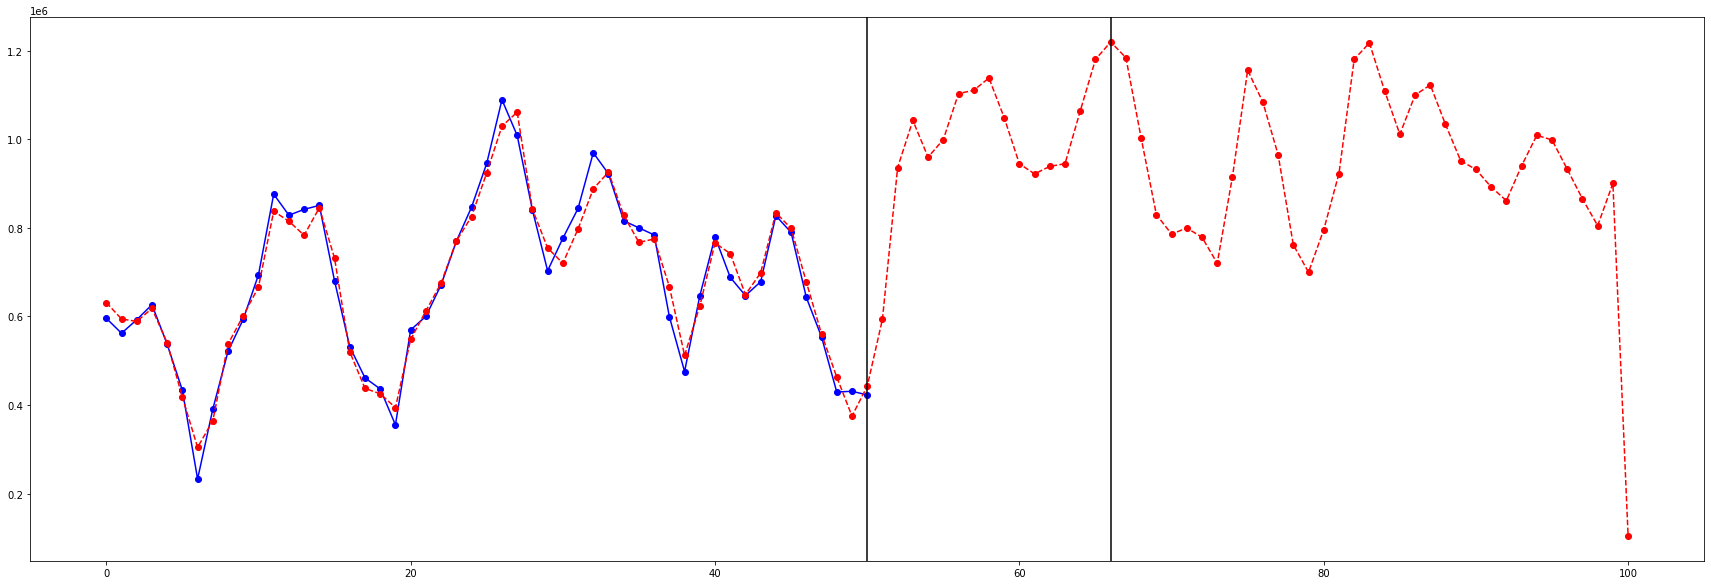

In [15]:
plt.figure(figsize=(30,10))
plt.plot(inven_history, color='blue', marker='o')
plt.plot(inven_predict, color='red', linestyle='dashed', marker='o')
plt.axvline(len(train_set['inven'])-1, c='k')
plt.axvline(len(d_set['inven'])-1, c='k')

In [24]:
print(len(inven_predict))
print(len(inven_history))
print(inven_predict[97:101]) 
day_set.loc[100]

101
101
97     865309.993043
98     804837.225842
99     900140.143889
100    103954.393295
Name: inven_pred, dtype: float64


ww            202150.000000
inven           -999.000000
inven_pred    103954.393295
sale          192620.000000
inven_d            0.000000
Name: 100, dtype: float64